# Propagation Characteristics of Outdoor Terrains

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy      as np

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
# importing necessary modules for simulating channel model
import sys
sys.path.append("../../../")

from toolkit5G.ChannelModels import NodeMobility
from toolkit5G.ChannelModels import AntennaArrays
from toolkit5G.ChannelModels import SimulationLayout
from toolkit5G.ChannelModels import ParameterGenerator
from toolkit5G.ChannelModels import ChannelGenerator

## Simulation Parameters

In [4]:

carrierFrequency = 3*10**9         # Array of two carrier frequencies in Hz
terrain          = "RMa"
nBSs             = 1 # number of BSs 
nUEs             = 10000              # number of UEs 
nSnapShots       = 1               # number of SnapShots

## Antenna Arrays

In [5]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType     = "3GPP_38.901",
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,1,1,1]))
bsAntArray() 

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType     = "OMNI",
                           centerFrequency = carrierFrequency,
                           arrayStructure  = np.array([1,1,1,1,1]))
ueAntArray() 


## Simulation Layout

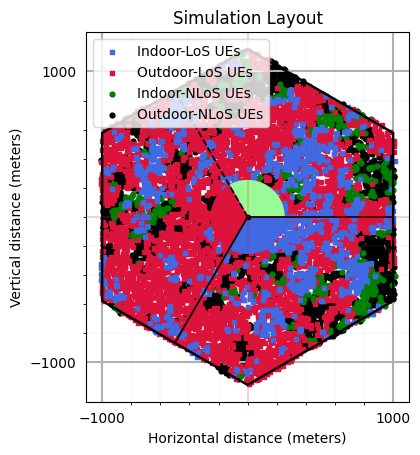

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Simulation Layout'}, xlabel='Horizontal distance (meters)', ylabel='Vertical distance (meters)'>)

In [6]:
# Layout Parameters
isd                  = 2000        # inter site distance
minDist              = 35          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 35          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
nSectorsPerSite      = 3           # number of sectors per site
ceilingHeight        = 3

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                UEdistibution = "random",
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                numOfSectorsPerSite = nSectorsPerSite)

simLayoutObj(terrain = terrain, carrierFreq = carrierFrequency, ueAntennaArray = ueAntArray, 
             bsAntennaArray = bsAntArray,  heightOfRoom = ceilingHeight, minNumberOfFloors = 1, 
             maxNumberOfFloors = 1, forceLOS = False, clutterHeight = 3, clutterSize = 10)

simLayoutObj.display2DTopology(refBS=0)


## Compute the Rough estimate of the Probability of line of sight

In [7]:
nBins      = 100
pLoS       = simLayoutObj.linkState[0, 0:np.prod(simLayoutObj.numOfBS), np.prod(simLayoutObj.numOfBS)::].flatten()
dist       = simLayoutObj.d2D[      0, 0:np.prod(simLayoutObj.numOfBS), np.prod(simLayoutObj.numOfBS)::].flatten()
indices    = np.argsort(dist)

distance   = dist[indices].reshape(-1, nBins).mean(axis = -1).flatten()
probOfLoS  = pLoS[indices].reshape(-1, nBins).mean(axis = -1).flatten()
temp       = simLayoutObj.probLOS[0,0:np.prod(simLayoutObj.numOfBS),np.prod(simLayoutObj.numOfBS)::].flatten()[indices].reshape(-1, nBins).mean(axis = -1).flatten()


In [8]:
simLayoutObj.probLOS.shape

(1, 10001, 10001)

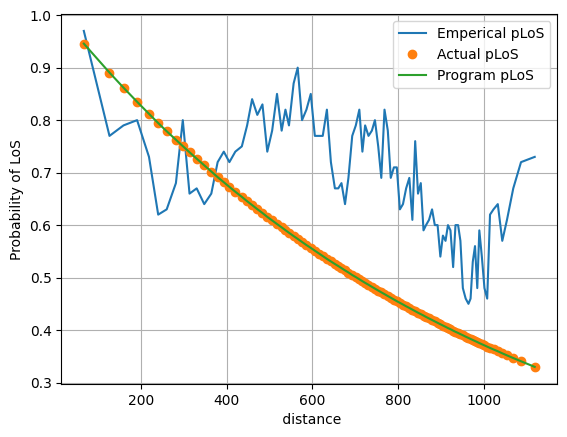

In [9]:
fig, ax = plt.subplots()
if(terrain == "RMa"):
    probLoS = np.ones(distance.shape)
    probLoS[distance>10] = np.exp(-(distance-10)/1000)[distance>10]
    
elif(terrain == "UMa"):
    probLoS = np.ones(distance.shape)
    probLoS[distance>10] = np.exp(-(distance-10)/1000)[distance>10]
    
elif(terrain == "UMi"):
    probLoS = np.ones(distance.shape)
    probLoS[distance>18] = 18/distance[distance>18] + (1-18/distance[distance>18])*np.exp(-distance[distance>18]/36)
    
ax.plot(distance, probOfLoS,    label="Emperical pLoS")
ax.plot(distance, probLoS, "o", label="Actual pLoS")
ax.plot(distance, temp,         label="Program pLoS")
ax.legend()
ax.set_xlabel(" distance")
ax.set_ylabel("Probability of LoS")

ax.grid()
plt.show()

## Parameter Generator

In [10]:
paramGen    = simLayoutObj.getParameterGenerator()

dist        = simLayoutObj.d3D[0, 0:np.prod(simLayoutObj.numOfBS), np.prod(simLayoutObj.numOfBS)::].flatten()
indices     = np.argsort(dist)

distance    = dist[indices].reshape(-1, nBins).mean(axis = -1).flatten()
pathLoss    = paramGen.pathLoss.flatten()[indices].reshape(-1, nBins).mean(axis = -1).flatten()
delaySpread = paramGen.delaySpread.flatten()
aoaSpread   = paramGen.phiAoA_spread.flatten()
aodSpread   = paramGen.phiAoD_spread.flatten()
zoaSpread   = paramGen.thetaAoA_spread.flatten()
zodSpread   = paramGen.thetaAoD_spread.flatten()
shadowFading= paramGen.shadowFading.flatten()
kFactor     = paramGen.kFactor.flatten()

[Warning]: UE height 'hUE' cannot be less than 1! These values are forced to 1!
[Warning]: 2D distances 'd2D' should lie between 1m and 10km! Some distances are from outside this interval!
Ignoring for now but might result in unexpected results!
dBP (min, max): 2199.114990234375, 9894.400634765625
[Warning]: UE height 'hUE' cannot be less than 1! These values are forced to 1!
[Warning]: 2D distances 'd2D' should lie between 1m and 10km! Some distances are from outside this interval!
Ignoring for now but might result in unexpected results!
dBP (min, max): 2199.114990234375, 9894.400634765625


## Path-loss Characteristics

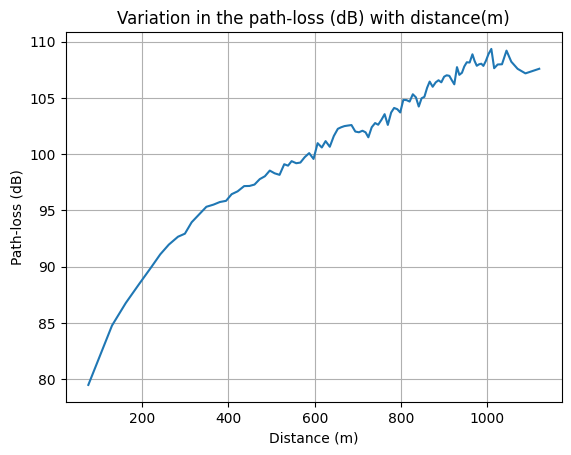

In [11]:
fig, ax = plt.subplots()

ax.plot(distance, pathLoss)
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Path-loss (dB)")
ax.set_title("Variation in the path-loss (dB) with distance(m)")
ax.grid()

plt.show()

### Distribution of Shadow fading

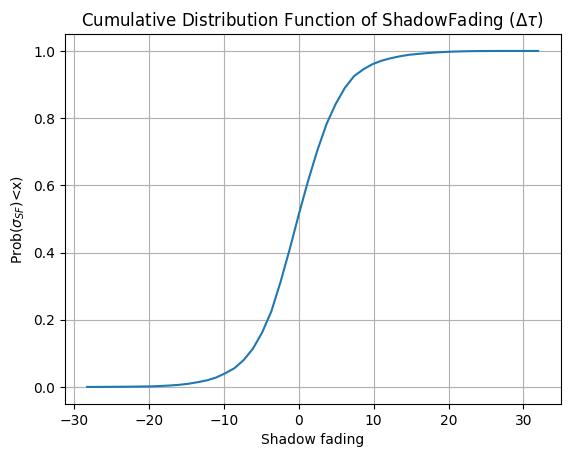

In [12]:
# plotting PDF and CDF
fig, ax = plt.subplots()

count_SF, bins_count_SF = np.histogram(shadowFading.flatten(), bins=50)

# finding the PDF of the histogram using count values
pdf = count_SF/sum(count_SF)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)

# ax.plot(bins_count[1:], pdf, label="PDF")
ax.plot(bins_count_SF[1:], cdf)
    
ax.set_title("Cumulative Distribution Function of ShadowFading ($\Delta \\tau$)")
ax.set_xlabel("Shadow fading")
ax.set_ylabel("Prob($ \\sigma_{SF} $)<x)")
ax.grid()

plt.show()

### Probability Distribution of Rician K factor

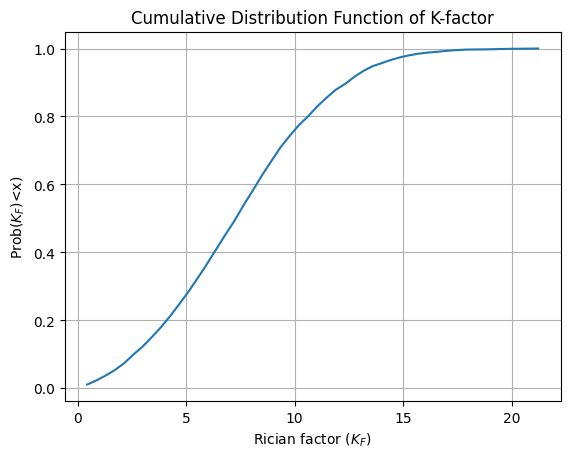

In [13]:
# plotting PDF and CDF
fig, ax = plt.subplots()

count_KF, bins_count_KF = np.histogram(kFactor[kFactor>0].flatten(), bins=50)

# finding the PDF of the histogram using count values
pdf = count_KF/sum(count_KF)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)

# ax.plot(bins_count[1:], pdf, label="PDF")
ax.plot(bins_count_KF[1:], cdf)
    
ax.set_title("Cumulative Distribution Function of K-factor")
ax.set_xlabel("Rician factor ($K_F$)")
ax.set_ylabel("Prob($ K_{F} $)<x)")
ax.grid()

plt.show()

## Delay Spread Charateristics

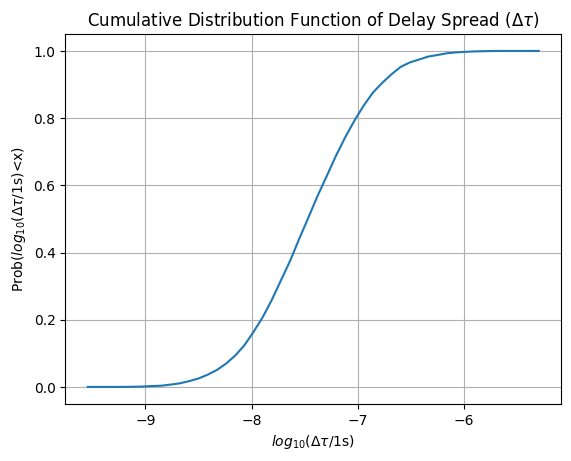

In [14]:
# plotting PDF and CDF
fig, ax = plt.subplots()

count, bins_count = np.histogram(np.log10(delaySpread.flatten()), bins=50)

# finding the PDF of the histogram using count values
pdf = count/sum(count)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)

# ax.plot(bins_count[1:], pdf, label="PDF")
ax.plot(bins_count[1:], cdf)
    
ax.set_title("Cumulative Distribution Function of Delay Spread ($\Delta \\tau$)")
ax.set_xlabel("$log_{10}(\Delta \\tau $/1s)")
ax.set_ylabel("Prob($log_{10}(\Delta \\tau $/1s)<x)")
ax.grid()

plt.show()

## Angular Spread Characteristics

### Probability distribution of Azimuth-AoA

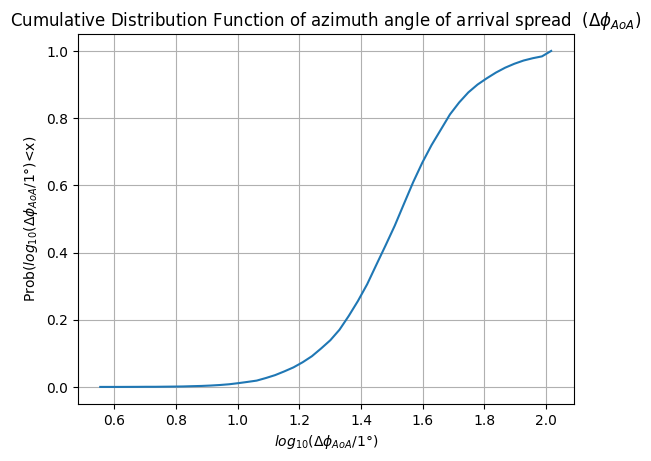

In [15]:
# plotting PDF and CDF
fig, ax = plt.subplots()

# getting data of the histogram
count_phiAoA, bins_count_phiAoA   = np.histogram(np.log10(aoaSpread.flatten()), bins=50)

# finding the PDF of the histogram using count values
pdf_phiAoA = count_phiAoA/sum(count_phiAoA)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_phiAoA = np.cumsum(pdf_phiAoA)

ax.plot(bins_count_phiAoA[1:], cdf_phiAoA)
    
ax.set_title("Cumulative Distribution Function of azimuth angle of arrival spread  ($\Delta \phi_{AoA}$)")
ax.set_xlabel("$log_{10}(\Delta \phi_{AoA} /1\degree$)")
ax.set_ylabel("Prob($log_{10}(\Delta \phi_{AoA} /1 \degree$)<x)")
ax.grid()

plt.show()

### Probability distribution of Azimuth-AoD

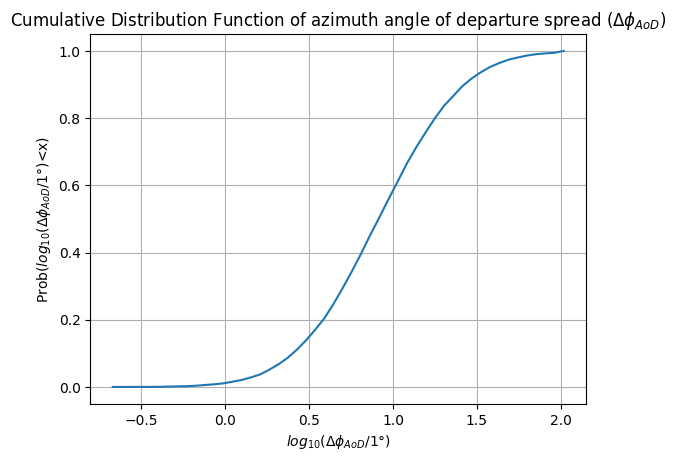

In [16]:
# plotting PDF and CDF
fig, ax = plt.subplots()

# getting data of the histogram
count_phiAoD,   bins_count_phiAoD   = np.histogram(np.log10(aodSpread.flatten()), bins=50)


# finding the PDF of the histogram using count values
pdf_phiAoD   = count_phiAoD/sum(count_phiAoD)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_phiAoD   = np.cumsum(pdf_phiAoD)

# plotting PDF and CDF
ax.plot(bins_count_phiAoD[1:], cdf_phiAoD)
    
ax.set_title("Cumulative Distribution Function of azimuth angle of departure spread ($\Delta \phi_{AoD}$)")
ax.set_xlabel("$log_{10}(\Delta \phi_{AoD} /1\degree$)")
ax.set_ylabel("Prob($log_{10}(\Delta \phi_{AoD} /1 \degree$)<x)")
ax.grid()

plt.show()

### Probability distribution of Elevation-AoA

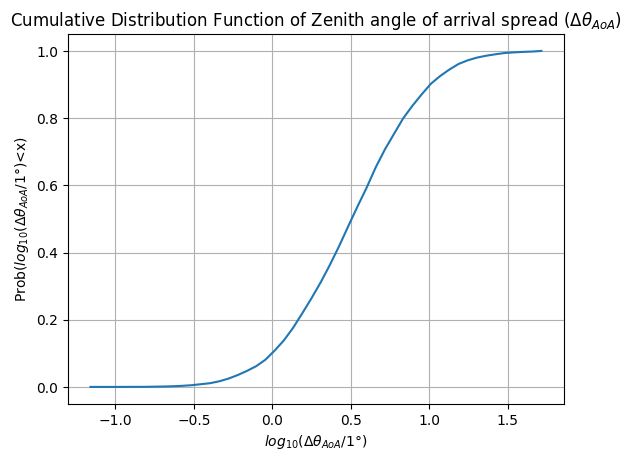

In [17]:
# plotting PDF and CDF
fig, ax = plt.subplots()

# getting data of the histogram
count_thetaAoA, bins_count_thetaAoA = np.histogram(np.log10(zoaSpread.flatten()), bins=50)

# finding the PDF of the histogram using count values
pdf_thetaAoA = count_thetaAoA/sum(count_thetaAoA)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_thetaAoA = np.cumsum(pdf_thetaAoA)

# plotting PDF and CDF
ax.plot(bins_count_thetaAoA[1:], cdf_thetaAoA)

ax.set_title("Cumulative Distribution Function of Zenith angle of arrival spread ($\Delta \\theta_{AoA}$)")
ax.set_xlabel("$log_{10}(\Delta \\theta_{AoA} /1\degree$)")
ax.set_ylabel("Prob($log_{10}(\Delta \\theta_{AoA} /1 \degree$)<x)")
ax.grid()

plt.show()

### Probability distribution of Elevation-AoD

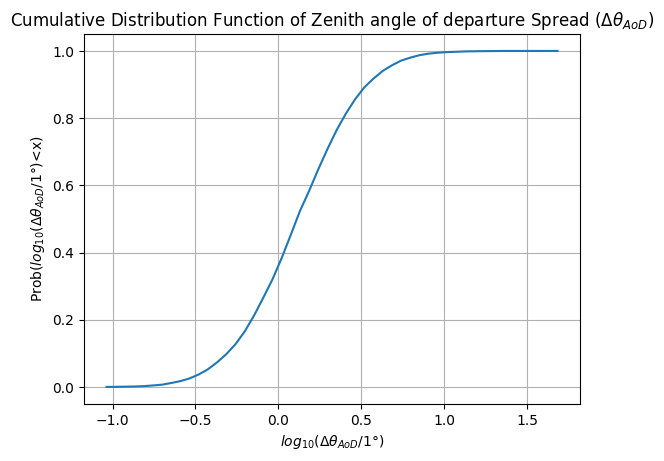

In [18]:
# plotting PDF and CDF
fig, ax = plt.subplots()

# getting data of the histogram
count_thetaAoD, bins_count_thetaAoD = np.histogram(np.log10(zodSpread.flatten()), bins=50)

# finding the PDF of the histogram using count values
pdf_thetaAoD = count_thetaAoD/sum(count_thetaAoD)

# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_thetaAoD = np.cumsum(pdf_thetaAoD)

# plotting PDF and CDF
ax.plot(bins_count_thetaAoD[1:], cdf_thetaAoD)
    
ax.set_title("Cumulative Distribution Function of Zenith angle of departure Spread ($\Delta \\theta_{AoD}$)")
ax.set_xlabel("$log_{10}(\Delta \\theta_{AoD} /1\degree$)")
ax.set_ylabel("Prob($log_{10}(\Delta \\theta_{AoD} /1 \degree$)<x)")
ax.grid()

plt.show()